In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy 
import matplotlib.pyplot as plt
from tqdm import tqdm

### Confirming Device

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

### Initialize Some Parameters

In [16]:
image_size = 64 
batch_size = 64

nz         = 100
beta1      = 0.5    # Stable training for the Adam optimizer 
beta2      = 0.999  # Usual value 
lr         = 0.0002 # 0.001 was too high according to the paper
sample_size= 64 
epochs     = 40

T = 100

### Loading CIFAR10 Data

In [17]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), 
    (0.5, 0.5, 0.5)),
])

In [18]:
train_data = datasets.CIFAR10(
    root = './data',
    train = True,
    download = True, 
    transform = transform 
)

Files already downloaded and verified


In [19]:
train_loader = DataLoader(train_data, 
                          batch_size = batch_size,
                          shuffle = True
                          , drop_last = True)

## Diffusion Model Implementation

### Latent Parameter Generation

In [20]:
# Notation of the research paper is followed here 
betas = torch.linspace(0.001, 0.02, T, device = device)

alphas              = 1 - betas 
inv_alphas_sqrt     = torch.sqrt(1/alphas)
alphas_bar          = torch.cumprod(alphas, dim = 0)
alphas_bar_sqrt     = torch.sqrt(alphas_bar) 
sub_alphas_bar_sqrt = torch.sqrt(1 - alphas_bar)
alphas_bar_prev     = F.pad(alphas_bar, (1,0), value = 1.0)



### Function to generate and add noise to image

In [21]:
def generate_noise(x):
    return torch.randn_like(x, device = device) 

In [22]:
def add_noise(x, epsilon, t):
    # Adds noise to the data
    alphas_bar_sqrt_cur = alphas_bar_sqrt[t] 

    # Now 
    sub_alphas_bar_sqrt_cur = sub_alphas_bar_sqrt[t] 

    # Now return noised data 
    noised_x = alphas_bar_sqrt_cur[:, None, None, None] * x + sub_alphas_bar_sqrt_cur[:, None, None, None] * epsilon 

    return noised_x

### Denoiser (UNet Architecture)

In [24]:
from torch import nn
import math


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)
        
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings

class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128,256, 512)
        up_channels = (512, 256, 128, 64)
        out_dim = 3 
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
        )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])
        
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

model = SimpleUnet().to(device) 
print("Num params: ", sum(p.numel() for p in model.parameters()))
model


Num params:  15453667


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor

### Training Loop (According to Paper)

In [25]:
# model = SimpleUNet(in_channels = 3, out_channels = 3).to(device)

criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [26]:
epochs = 40
losses = []
for e in range(epochs):
    final_loss = 0.0
    i = 0
    for _,data in tqdm(enumerate(train_loader), total = int(len(train_data)/train_loader.batch_size)):
        x, y = data
        x = x.to(device)
        y = y.to(device) 
        optimizer.zero_grad()
        
        # Selected t uniformly 
        indexes = torch.randint(0, T , size = (batch_size,), device = device)  

        # Select x from the dataset
        epsilon = generate_noise(x) 

        # Add this to generate noisy data
        noisy   = add_noise(x, epsilon, indexes)

        # output
        output = model(noisy, indexes)

        loss   = criterion(output, epsilon)

        loss.backward()

        optimizer.step()

        final_loss += loss.item() 

        i += 1
    
    losses.append(final_loss/i) 
    
    print(f"Epoch {e+1} of {epochs}")
    print(f"UNet Loss: {(final_loss/i):.8f}")  

100%|██████████| 781/781 [04:55<00:00,  2.65it/s]


Epoch 1 of 40
UNet Loss: 0.07004470


100%|██████████| 781/781 [04:59<00:00,  2.61it/s]


Epoch 2 of 40
UNet Loss: 0.03788067


100%|██████████| 781/781 [04:59<00:00,  2.61it/s]


Epoch 3 of 40
UNet Loss: 0.03419490


100%|██████████| 781/781 [04:59<00:00,  2.60it/s]


Epoch 4 of 40
UNet Loss: 0.03203605


100%|██████████| 781/781 [04:57<00:00,  2.63it/s]


Epoch 5 of 40
UNet Loss: 0.02986555


100%|██████████| 781/781 [04:57<00:00,  2.63it/s]


Epoch 6 of 40
UNet Loss: 0.04191028


100%|██████████| 781/781 [04:57<00:00,  2.63it/s]


Epoch 7 of 40
UNet Loss: 0.03391068


100%|██████████| 781/781 [04:57<00:00,  2.62it/s]


Epoch 8 of 40
UNet Loss: 0.03264940


100%|██████████| 781/781 [04:57<00:00,  2.63it/s]


Epoch 9 of 40
UNet Loss: 0.03168752


100%|██████████| 781/781 [04:57<00:00,  2.62it/s]


Epoch 10 of 40
UNet Loss: 0.03086060


100%|██████████| 781/781 [04:57<00:00,  2.62it/s]


Epoch 11 of 40
UNet Loss: 0.02940223


100%|██████████| 781/781 [04:57<00:00,  2.62it/s]


Epoch 12 of 40
UNet Loss: 0.02846953


100%|██████████| 781/781 [06:08<00:00,  2.12it/s]


Epoch 13 of 40
UNet Loss: 0.02779480


100%|██████████| 781/781 [06:26<00:00,  2.02it/s]


Epoch 14 of 40
UNet Loss: 0.02743379


100%|██████████| 781/781 [04:50<00:00,  2.69it/s]


Epoch 15 of 40
UNet Loss: 0.02729683


100%|██████████| 781/781 [04:58<00:00,  2.62it/s]


Epoch 16 of 40
UNet Loss: 0.02700135


100%|██████████| 781/781 [04:58<00:00,  2.62it/s]


Epoch 17 of 40
UNet Loss: 0.02703158


100%|██████████| 781/781 [05:00<00:00,  2.60it/s]


Epoch 18 of 40
UNet Loss: 0.02673788


100%|██████████| 781/781 [04:58<00:00,  2.61it/s]


Epoch 19 of 40
UNet Loss: 0.02673559


100%|██████████| 781/781 [04:59<00:00,  2.61it/s]


Epoch 20 of 40
UNet Loss: 0.02650766


100%|██████████| 781/781 [04:58<00:00,  2.62it/s]


Epoch 21 of 40
UNet Loss: 0.02642993


100%|██████████| 781/781 [04:57<00:00,  2.63it/s]


Epoch 22 of 40
UNet Loss: 0.02624918


100%|██████████| 781/781 [04:57<00:00,  2.63it/s]


Epoch 23 of 40
UNet Loss: 0.02631734


100%|██████████| 781/781 [04:57<00:00,  2.63it/s]


Epoch 24 of 40
UNet Loss: 0.02619323


100%|██████████| 781/781 [04:57<00:00,  2.63it/s]


Epoch 25 of 40
UNet Loss: 0.02616897


100%|██████████| 781/781 [04:56<00:00,  2.63it/s]


Epoch 26 of 40
UNet Loss: 0.02621306


100%|██████████| 781/781 [04:58<00:00,  2.62it/s]


Epoch 27 of 40
UNet Loss: 0.02612523


100%|██████████| 781/781 [04:58<00:00,  2.62it/s]


Epoch 28 of 40
UNet Loss: 0.02601091


100%|██████████| 781/781 [04:57<00:00,  2.63it/s]


Epoch 29 of 40
UNet Loss: 0.02596485


100%|██████████| 781/781 [04:56<00:00,  2.63it/s]


Epoch 30 of 40
UNet Loss: 0.02588702


100%|██████████| 781/781 [04:54<00:00,  2.65it/s]


Epoch 31 of 40
UNet Loss: 0.02576850


100%|██████████| 781/781 [04:55<00:00,  2.64it/s]


Epoch 32 of 40
UNet Loss: 0.02595231


100%|██████████| 781/781 [04:55<00:00,  2.64it/s]


Epoch 33 of 40
UNet Loss: 0.02586741


100%|██████████| 781/781 [04:55<00:00,  2.64it/s]


Epoch 34 of 40
UNet Loss: 0.02587577


100%|██████████| 781/781 [04:55<00:00,  2.64it/s]


Epoch 35 of 40
UNet Loss: 0.02578091


100%|██████████| 781/781 [04:55<00:00,  2.64it/s]


Epoch 36 of 40
UNet Loss: 0.02586537


100%|██████████| 781/781 [04:56<00:00,  2.64it/s]


Epoch 37 of 40
UNet Loss: 0.02731457


100%|██████████| 781/781 [04:57<00:00,  2.63it/s]


Epoch 38 of 40
UNet Loss: 0.02596315


100%|██████████| 781/781 [04:54<00:00,  2.65it/s]


Epoch 39 of 40
UNet Loss: 0.02569750


100%|██████████| 781/781 [04:55<00:00,  2.65it/s]

Epoch 40 of 40
UNet Loss: 0.02571423


In [28]:
torch.save(model.state_dict(),'diff_model.pth')

### Loss vs Epoch curve for training 

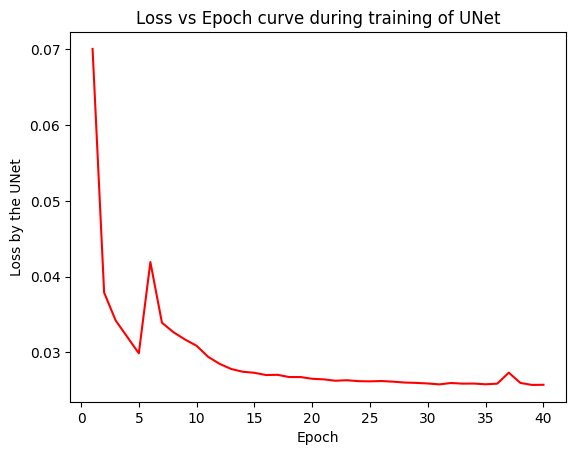

In [29]:
import matplotlib.pyplot as plt 

epoches = list(range(1, epochs + 1))

plt.plot(epoches, losses, color = 'red')

plt.xlabel('Epoch')
plt.ylabel('Loss by the UNet')
plt.title('Loss vs Epoch curve during training of UNet') 

plt.show() 

### Sampling Part

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

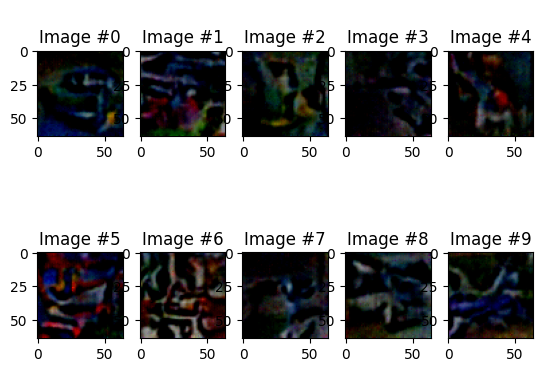

In [31]:
# Sigmas 
sigmas = torch.sqrt(betas)

@torch.no_grad()
def sampling(n = 10):
    # Generate samples 
    x = torch.randn(n, 3, 64, 64, device = device)
 
    for t in range(T - 1, -1, -1):
        z = None 
        if t > 0:
            z = torch.randn(n, 3, 64, 64,device = device) 
        else: 
            z = torch.zeros(n, 3, 64, 64, device = device) 
        
        time_tensor = torch.full((n,),t, device = device)
        
        eps = model(x, time_tensor) 

        x = x - (betas[t]/sub_alphas_bar_sqrt[t]) * eps + (((1 - alphas_bar[t - 1])/(1 - alphas_bar[t]) * betas[t])**0.5) * z

        x = inv_alphas_sqrt[t] * x 
    
    return x 


images = sampling()

fig = plt.figure()

plt.axis('off')
def show_image(img, i):
    plt.title('Image #' + str(i))
    plt.imshow(img.cpu().permute(1,2,0))

for i in range(len(images)):
    fig.add_subplot(2, 5, i + 1)
    show_image(images[i],i)

plt.show()

In [32]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
import torch.utils.data

from torchvision.models.inception import inception_v3

import numpy as np
from scipy.stats import entropy

def inception_score(imgs, cuda=True, batch_size=32, resize=False, splits=1):
    """Computes the inception score of the generated images imgs

    imgs -- Torch dataset of (3xHxW) numpy images normalized in the range [-1, 1]
    cuda -- whether or not to run on GPU
    batch_size -- batch size for feeding into Inception v3
    splits -- number of splits
    """
    N = len(imgs)

    assert batch_size > 0
    assert N > batch_size

    # Set up dtype
    if cuda:
        dtype = torch.cuda.FloatTensor
    else:
        if torch.cuda.is_available():
            print("WARNING: You have a CUDA device, so you should probably set cuda=True")
        dtype = torch.FloatTensor

    # Set up dataloader
    dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)

    # Load inception model
    inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
    inception_model.eval();
    up = nn.Upsample(size=(299, 299), mode='bilinear').type(dtype)
    def get_pred(x):
        if resize:
            x = up(x)
        x = inception_model(x)
        return F.softmax(x).data.cpu().numpy()

    # Get predictions
    preds = np.zeros((N, 1000))

    for i, batch in enumerate(dataloader, 0):
        batch = batch.type(dtype)
        batchv = Variable(batch)
        batch_size_i = batch.size()[0]

        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batchv)

    # Now compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)


inception_score(images, batch_size = 1, resize = True)   

/home/aman/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aman/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_3364/3643015077.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x).data.cpu().numpy()


(1.6818822811464238, 0.0)